### Solving Poisson Equation on S^2: $\Delta u = f$


iteration 0: loss = 99.9778823852539


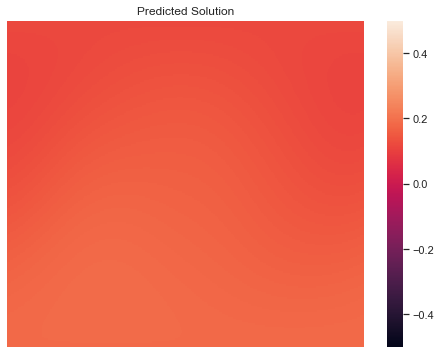

iteration 10: loss = 98.23710632324219
iteration 20: loss = 93.86009216308594
iteration 30: loss = 85.54306030273438
iteration 40: loss = 60.00054931640625
iteration 50: loss = 57.124244689941406
iteration 60: loss = 48.62615203857422
iteration 70: loss = 28.766277313232422
iteration 80: loss = 15.90070629119873
iteration 90: loss = 8.93363094329834
iteration 100: loss = 7.278510093688965


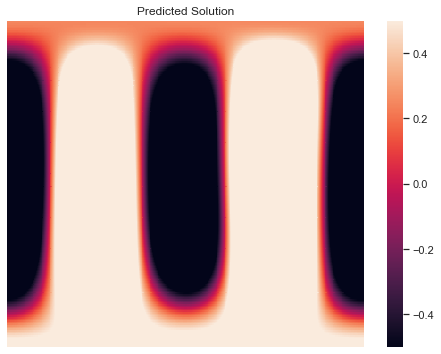

iteration 110: loss = 6.079490661621094
iteration 120: loss = 5.383796215057373
iteration 130: loss = 4.964435577392578
iteration 140: loss = 4.290203094482422
iteration 150: loss = 3.913194417953491
iteration 160: loss = 3.717770576477051
iteration 170: loss = 3.5680620670318604
iteration 180: loss = 3.3598108291625977
iteration 190: loss = 3.154221773147583
iteration 200: loss = 2.99973464012146


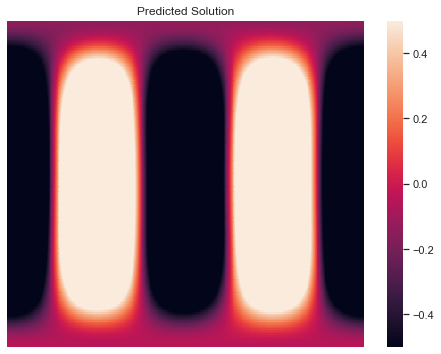

iteration 210: loss = 2.764575242996216
iteration 220: loss = 2.819739580154419


In [ ]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos

torch.manual_seed(0)
maxiter = 1001
problem = Problem_Sphere_Poisson()


def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, num=200):
            N = 25
            cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
            azimuth = torch.arccos(cos_azimuth)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            ## noise
            dpolar = 2*pi/(2*N-1)
            dazimuth = 2.0/(N-1)
            polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
            
            azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            return location
#             x = torch.randn(num, 3)
#             x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
        
#             polar = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
#             polar[:num // 2, 0] = polar[:num // 2, 0] + math.pi
#             azimuth = torch.acos(x[:, 2:3])
            
#             ## noise
#             dpolar = 2 * pi/(num-1) 
#             polar_noise = polar + torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            
#             dazimuth = pi/(num-1) 
#             azimuth_noise = azimuth + torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(polar.shape))            
            
#             x = torch.cat([azimuth_noise, polar_noise], dim=1)
#             return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, 200, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, 200, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample(num=1000)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                        
                if iter % int(maxiter / 10) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
